In [60]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import skfda
from scipy import ndimage as ndi
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [31]:
ex = experiment.PairExperiment(
    Path('/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47'),
    'TL/470/410/470/410',
    register=False
).full_pipeline()

09:30:04 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
09:30:04 INFO:Segmenting pharynxes
09:30:06 INFO:Centering and rotating pharynxes


09:30:15 INFO:Calculating midlines


09:30:16 INFO:Measuring under midlines


09:30:18 INFO:Trimming intensity data


09:30:18 INFO:Calculating redox measurements
09:30:18 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
09:30:18 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-16_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
09:30:19 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-16_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
09:30:19 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47


In [64]:
df = ex.movement
df = pd.DataFrame(df.to_records())
df
np.concatenate(np.array(
    [
        df[(df.pair == 0) & (df.anterior == 0) & (df.posterior == 0)].animal.values,
        df[(df.pair == 1) & (df.anterior == 0) & (df.posterior == 0)].animal.values,
    ]
))

array([  0,   1,   2,   3,   4,   7,   8,   9,  11,  12,  13,  14,  15,
        16,  19,  20,  21,  22,  24,  25,  26,  27,  28,  30,  33,  34,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  51,  53,  54,  55,  56,  57,  58,  59,  60,  61,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  89,  91,  92,
        93,  94,  95,  98,  99, 100, 101, 104, 105, 106, 107, 108, 109,
       110, 111, 113, 114, 116, 117, 118, 120, 121, 122,   0,   2,   3,
         4,   5,   6,   7,   8,   9,  13,  14,  15,  16,  17,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  37,  38,  39,  40,  41,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  70,  71,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  89,  90,  9

In [148]:
df.pair.unique()

array([0, 1])

In [260]:
reload(utils);
shifted_meas, shifts = utils.measure_shifted_midlines(ex, (-1, 1), 3)

(615, 5, 2, 200)

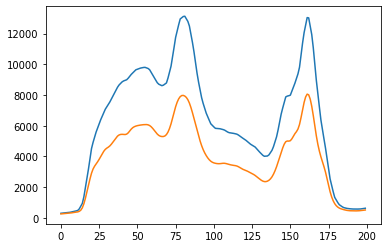

In [259]:
i += 50
# i = 0
plt.plot(shifted_meas.sel(wavelength='410', pair=1)[i]);
plt.plot(shifted_meas.sel(wavelength='470', pair=1)[i]);

In [25]:
def load_all_cached_profile_data(glob_pattern):
    return xr.concat((xr.load_dataarray(p) for p in sorted(meta_dir.glob(glob_pattern))), dim='strain')

meta_dir = Path("/Users/sean/code/pharynx_redox/data/paired_ratio")
raw_prof = load_all_cached_profile_data('**/*single_unreg/*.nc')

df = da.load_all_summaries(meta_dir)
df = df.reset_index(drop=True)

df['total'] = df['anterior'] + df['posterior'] + df['sides_of_tip'] + df['tip']
df = df.pivot_table(index=['animal', 'experiment', 'strategy'], columns='pair').reset_index()

df = df.sort_values(['experiment', 'animal'])
df.index.rename('index', inplace=True)

df = df[df.strategy=='skfda_reg'].reset_index(drop=True)
df.index.rename('index', inplace=True)

df

animal               experiment   strategy          410               \
pair                                                        0            1   
index                                                                        
0          0   2017_02_22-HD233_SAY47  skfda_reg  7736.690185  7772.451718   
1          1   2017_02_22-HD233_SAY47  skfda_reg  8121.264270  8538.297062   
2          2   2017_02_22-HD233_SAY47  skfda_reg  9117.918145  9033.453766   
3          3   2017_02_22-HD233_SAY47  skfda_reg  8295.076038  8315.887954   
4          4   2017_02_22-HD233_SAY47  skfda_reg  8418.941541  8269.410921   
...      ...                      ...        ...          ...          ...   
858      118  2019_04_03-ASI_ablation  skfda_reg  7606.941331  7516.936125   
859      119  2019_04_03-ASI_ablation  skfda_reg  6933.754302  6901.352778   
860      120  2019_04_03-ASI_ablation  skfda_reg  7467.512869  7386.310088   
861      121  2019_04_03-ASI_ablation  skfda_reg  5754.036735  6295.536244   
862      122  2019_04_03-ASI_ablation  skfda_reg  7372.182651  7245.543383   

               470              anterior                e  ... posterior       \
pair             0            1        0    1           0  ...         0    1   
index                                                      ...                  
0      5440.170585  5419.553695      0.0  0.0 -270.729351  ...       0.0  0.0   
1      5597.391026  5902.850274      0.0  1.0 -269.968367  ...       0.0  1.0   
2      6662.137073  6520.554476      0.0  0.0 -272.110342  ...       0.0  0.0   
3      5579.429837  5550.171210      0.0  0.0 -269.168019  ...       0.0  0.0   
4      5641.785626  5543.846463      0.0  0.0 -268.818006  ...       0.0  0.0   
...            ...          ...      ...  ...         ...  ...       ...  ...   
858    6213.115739  6159.999758      NaN  NaN -276.632668  ...       NaN  NaN   
859    5521.573304  5535.818231      NaN  NaN -275.561351  ...       NaN  NaN   
860    6096.574540  6042.078491      NaN  NaN -276.520132  ...       NaN  NaN   
861    5193.800581  5744.692582      NaN  NaN -281.930633  ...       NaN  NaN   
862    6151.732153  6093.526017      NaN  NaN -277.557307  ...       NaN  NaN   

              r           sides_of_tip       tip      total       
pair          0         1            0    1    0    1     0    1  
index                                                             
0      1.423790  1.437423          0.0  0.0  1.0  0.0   1.0  0.0  
1      1.454323  1.451732          1.0  1.0  0.0  1.0   1.0  4.0  
2      1.368982  1.385356          0.0  0.0  0.0  0.0   0.0  0.0  
3      1.491342  1.502351          0.0  0.0  0.0  0.0   0.0  0.0  
4      1.508542  1.510266          0.0  0.0  0.0  0.0   0.0  0.0  
...         ...       ...          ...  ...  ...  ...   ...  ...  
858    1.224161  1.219197          NaN  NaN  NaN  NaN   NaN  NaN  
859    1.254814  1.247838          NaN  NaN  NaN  NaN   NaN  NaN  
860    1.227555  1.226574          NaN  NaN  NaN  NaN   NaN  NaN  
861    1.104744  1.091057          NaN  NaN  NaN  NaN   NaN  NaN  
862    1.200533  1.191611          NaN  NaN  NaN  NaN   NaN  NaN  

[863 rows x 23 columns]